In [0]:
%tensorflow_version 1.x

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import pandas as pd
import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model


Using TensorFlow backend.


In [0]:
dataset = pd.read_csv('/home/chandunagendramurthy/projects/hindencorp05.tsv', sep='\t', encoding = 'utf-8')

In [0]:
dataset.head()

,wikiner2013inflected,1-1,1.000,Sharaabi,शराबी
0,ted,1-1,1.0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,1-1,1.0,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,1-1,manual,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,quote-name,1-1,1.0,- John Collins,- जॉन कॉलिन्स
4,ted,1-1,1.0,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते


In [0]:
set(dataset['wikiner2013inflected'])

{'acl2005',
 'agro-exact',
 'agro-hunaligned',
 'danielpipes',
 'emille',
 'indic2012',
 'intercorp',
 'launchpad',
 'quote-name',
 'quote-sent',
 'ted',
 'tides',
 'wikiner2011',
 'wikiner2013',
 'wikiner2013inflected',
 'words-example',
 'words-word'}

In [0]:
dataset = dataset[dataset['wikiner2013inflected']=='ted']
dataset.head()

,wikiner2013inflected,1-1,1.000,Sharaabi,शराबी
0,ted,1-1,1.0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,1-1,1.0,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
4,ted,1-1,1.0,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
18,ted,1-1,1.0,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
29,ted,1-1,1.0,So there is some sort of justice,तो वहाँ न्याय है


In [0]:
dataset.drop(columns= ['wikiner2013inflected','1-1', '1.000'], inplace = True)
dataset.head()

,Sharaabi,शराबी
0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
4,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
18,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
29,So there is some sort of justice,तो वहाँ न्याय है


In [0]:
dataset.columns = ['english', 'hindi']
dataset.head()

,english,hindi
0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
4,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
18,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
29,So there is some sort of justice,तो वहाँ न्याय है


In [0]:
dataset.dropna(inplace=True)

In [0]:
dataset.drop_duplicates(inplace=True)

In [0]:
punctuations = set(string.punctuation)
# Preprocess the sentences by removing punctuations and digits and extra spaces
def preprocess_text(sentence):
  sentence = sentence.strip()

  sentence = sentence.lower()

  sentence = ''.join(ch for ch in sentence if ch not in punctuations)

  sentence = re.sub('\d+', '', sentence)
  sentence = re.sub('[२३०८१५७९४६]', '', sentence)

  sentence = re.sub(" +", " ", sentence)
  return sentence

In [0]:
# Preprocessing of the sentences
for index, row in dataset.iterrows():
  input_text = row['english']
  target_text = row['hindi']

  input_text = preprocess_text(input_text)
  target_text = preprocess_text(target_text)

  target_text = 'START_ ' + target_text + ' _END'
  
  dataset['english'][index] = input_text
  dataset['hindi'][index] = target_text

In [0]:
dataset.head()

,english,hindi
0,politicians do not have permission to do what ...,START_ राजनीतिज्ञों के पास जो कार्य करना चाहिए...
1,id like to tell you about one such child,START_ मई आपको ऐसे ही एक बच्चे के बारे में बता...
4,what we really mean is that theyre bad at not ...,START_ हम ये नहीं कहना चाहते कि वो ध्यान नहीं ...
18,and who are we to say even that they are wrong,START_ और हम होते कौन हैं यह कहने भी वाले कि व...
29,so there is some sort of justice,START_ तो वहाँ न्याय है _END


In [0]:
len(dataset)

38803

In [0]:
### Get English and Hindi Vocabulary
all_eng_words=set()
for eng in dataset['english']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_hindi_words=set()
for hin in dataset['hindi']:
    for word in hin.split():
        if word not in all_hindi_words:
            all_hindi_words.add(word)

In [0]:
len(all_eng_words)

17345

In [0]:
len(all_hindi_words)

22285

In [0]:
dataset['eng_len']=dataset['english'].apply(lambda x:len(x.split(" ")))
dataset['hin_len']=dataset['hindi'].apply(lambda x:len(x.split(" ")))

In [0]:
dataset.head()

,english,hindi,eng_len,hin_len
0,politicians do not have permission to do what ...,START_ राजनीतिज्ञों के पास जो कार्य करना चाहिए...,12,16
1,id like to tell you about one such child,START_ मई आपको ऐसे ही एक बच्चे के बारे में बता...,9,13
4,what we really mean is that theyre bad at not ...,START_ हम ये नहीं कहना चाहते कि वो ध्यान नहीं ...,12,13
18,and who are we to say even that they are wrong,START_ और हम होते कौन हैं यह कहने भी वाले कि व...,11,15
29,so there is some sort of justice,START_ तो वहाँ न्याय है _END,7,6


In [0]:
dataset[dataset['eng_len']>20].shape

(1, 4)

In [0]:
dataset=dataset[dataset['eng_len']<=10]
dataset=dataset[dataset['hin_len']<=10]

In [0]:
dataset.head()

,english,hindi,eng_len,hin_len
29,so there is some sort of justice,START_ तो वहाँ न्याय है _END,7,6
43,this changed slowly,START_ धीरे धीरे ये सब बदला _END,3,7
53,were being produced,START_ उत्पन्न नहीं कि जाती थी _END,3,7
67,can you imagine saying that,START_ क्या आप ये कल्पना कर सकते है _END,5,9
73,whats going on”,START_ क्या हो रहा है ये” _END,3,7


In [0]:
dataset.shape

(20458, 4)

In [0]:
max_length_src=max(dataset['hin_len'])
max_length_tar=max(dataset['eng_len'])

In [0]:
print("maximum length of Hindi Sentence ", max_length_src)
print("maximum length of English Sentence ", max_length_tar)

maximum length of Hindi Sentence  10
maximum length of English Sentence  10


In [0]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_hindi_words)
num_encoder_tokens, num_decoder_tokens

(17345, 22285)

In [0]:
num_decoder_tokens += 1 #for zero padding

In [0]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [0]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [0]:
dataset = dataset.sample(n=10000,random_state=42)

In [0]:
dataset = shuffle(dataset)

In [0]:
dataset.head()

,english,hindi,eng_len,hin_len
145950,i had absolutely no idea,START_ मुझे बिल्कुल भी नहीं पता था _END,5,8
10731,completely noninvasive and silent,START_ बिलकुल शांत और गैर भेदी _END,4,7
135415,the good teachers for a lot of these kids,START_ काफ़ी सारे बच्चो के लिए अच्छे शिक्षक _END,9,9
148731,and then thats her over there,START_ वो वहाँ पर यह लड़की है _END,6,8
110716,he found the peak covered with countless flags,START_ तो उसने उसे अनगिनत झंडों से ढका पाया _END,8,10


In [0]:
X, y = dataset['english'], dataset['hindi']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
x_train.shape, x_test.shape

((8000,), (2000,))

In [0]:
def generate_batch(X = x_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [0]:
latent_dim=300

In [0]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [0]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    5203500     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 300)    6685800     input_4[0][0]                    
____________________________________________________________________________________________

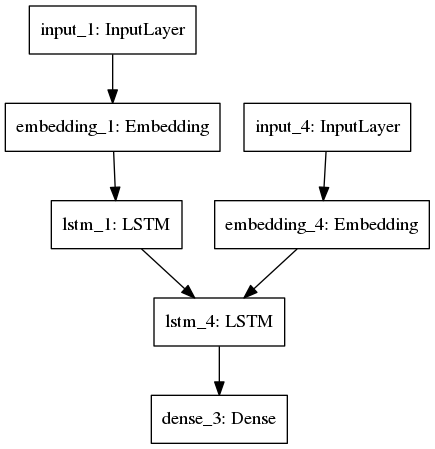

In [0]:
from keras.utils import plot_model
plot_model(model, 'model.png')

In [0]:
train_samples = len(x_train)
val_samples = len(x_test)
batch_size = 128
epochs = 100

In [0]:
train_samples//batch_size

62

In [0]:
model_history = model.fit_generator(generator = generate_batch(x_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(x_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

model.save_weights('nmt_weights.h5')

Epoch 1/100
62/62 [==============================] - 16s 266ms/step - loss: 4.4395 - val_loss: 4.0840
Epoch 2/100
62/62 [==============================] - 15s 249ms/step - loss: 3.7100 - val_loss: 4.0674
Epoch 3/100
62/62 [==============================] - 15s 249ms/step - loss: 3.4268 - val_loss: 4.1693
Epoch 4/100
62/62 [==============================] - 15s 248ms/step - loss: 3.2088 - val_loss: 4.1563
Epoch 5/100
62/62 [==============================] - 15s 249ms/step - loss: 3.0291 - val_loss: 3.9767
Epoch 6/100
62/62 [==============================] - 15s 248ms/step - loss: 2.8644 - val_loss: 4.0457
Epoch 7/100
62/62 [==============================] - 15s 249ms/step - loss: 2.7158 - val_loss: 4.0616
Epoch 8/100
62/62 [==============================] - 15s 248ms/step - loss: 2.5764 - val_loss: 4.0518
Epoch 9/100
62/62 [==============================] - 16s 250ms/step - loss: 2.4469 - val_loss: 3.6593
Epoch 10/100
62/62 [==============================] - 15s 249ms/step - loss: 2.321

62/62 [==============================] - 16s 250ms/step - loss: 0.0096 - val_loss: 3.4630
Epoch 81/100
62/62 [==============================] - 15s 250ms/step - loss: 0.0100 - val_loss: 5.5925
Epoch 82/100
62/62 [==============================] - 16s 251ms/step - loss: 0.0090 - val_loss: 5.5791
Epoch 83/100
62/62 [==============================] - 16s 251ms/step - loss: 0.0083 - val_loss: 6.0419
Epoch 84/100
62/62 [==============================] - 16s 251ms/step - loss: 0.0085 - val_loss: 5.9072
Epoch 85/100
62/62 [==============================] - 16s 251ms/step - loss: 0.0091 - val_loss: 5.7826
Epoch 86/100
62/62 [==============================] - 16s 251ms/step - loss: 0.0087 - val_loss: 5.8289
Epoch 87/100
62/62 [==============================] - 16s 250ms/step - loss: 0.0082 - val_loss: 5.9603
Epoch 88/100
62/62 [==============================] - 16s 252ms/step - loss: 0.0089 - val_loss: 5.9323
Epoch 89/100
62/62 [==============================] - 16s 250ms/step - loss: 0.0080 - 

In [0]:

encoder_model = Model(encoder_inputs, encoder_states)


decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) 


decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) 

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


In [0]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_token_index['START_']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        target_seq = np.zeros((1,1))index

        states_value = [h, c]

    return decoded_sentence

In [0]:
train_gen = generate_batch(x_train, y_train, batch_size = 1)
k=-1

In [0]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', x_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: than most of us have been led to believe
Actual Hindi Translation:  उससे काफी ज़्यादा सूक्ष्म है 
Predicted Hindi Translation:  उससे काफी ज़्यादा सूक्ष्म है 


In [0]:
test_gen = generate_batch(x_test, y_test, batch_size = 1)
k=-1